In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy import interpolate, signal, ndimage
from scipy import stats
from os import listdir
from os.path import isfile, join
from scipy.odr import Model, RealData, ODR
data_path = './data/cleaned/'
fig_path = './fig/'

# load csv
room = pd.read_csv(data_path + 'room.csv')
boil = pd.read_csv(data_path + 'boil.csv')
ice = pd.read_csv(data_path + 'ice.csv')
N2 = pd.read_csv(data_path + 'N2.csv')
room

,Unnamed: 0,TIME,V(V),I(nA),NAME,T(K),type
0,0,-20.000,-0.068255,-0.129299,room_temp_reverse_0.000nA.CSV,298.0,default
1,1,-19.992,-0.068255,-0.129298,room_temp_reverse_0.000nA.CSV,298.0,default
2,2,-19.985,-0.068253,-0.129297,room_temp_reverse_0.000nA.CSV,298.0,default
3,3,-19.977,-0.068251,-0.129296,room_temp_reverse_0.000nA.CSV,298.0,default
4,4,-19.969,-0.068247,-0.129294,room_temp_reverse_0.000nA.CSV,298.0,default
...,...,...,...,...,...,...,...
5397,4796,8.418,0.215984,35.654088,room_temp_forward_0.0000microA.CSV,298.0,default
5398,4797,8.422,0.215986,35.655912,room_temp_forward_0.0000microA.CSV,298.0,default
5399,4798,8.425,0.215988,35.657282,room_temp_forward_0.0000microA.CSV,298.0,default
5400,4799,8.429,0.215990,35.658195,room_temp_forward_0.0000microA.CSV,298.0,default


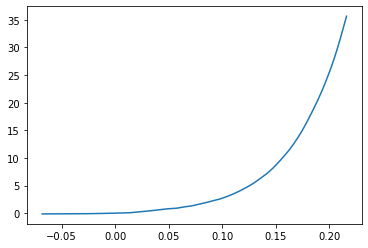

In [2]:
plt.plot(room['V(V)'], room['I(nA)'])

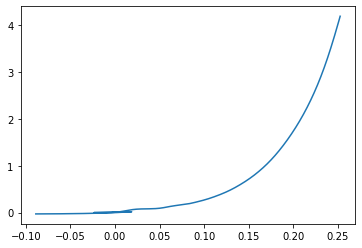

In [3]:
plt.plot(boil['V(V)'], boil['I(nA)'])

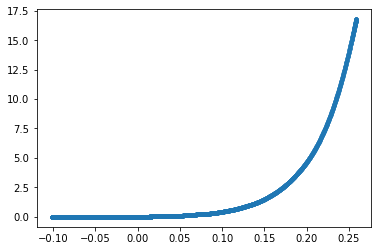

In [4]:
plt.plot(ice['V(V)'], ice['I(nA)'], '.')

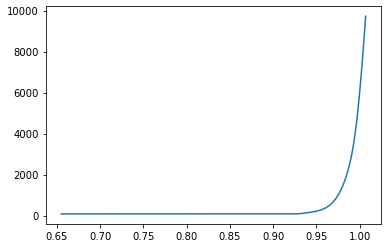

In [5]:
plt.plot(N2['V(V)'], N2['I(nA)'])

In [6]:
# complicated model
def I(params, V_T):
    k = 1.38e-23
    q = 1.6e-19
    V = V_T[0]
    T = V_T[1]
    B_rec, B_diff, E_g= params
    I_rec = B_rec * T**1.5 * np.exp(-E_g/(2 * k * T)) * (np.exp(q * V / (2 * k * T)) - 1)
    I_diff = B_diff * T**3 * np.exp(-E_g/(k * T)) * (np.exp(q * V / (k * T)) - 1)
    return I_rec + I_diff
# simpler model
def I2(params, V_T):
    k = 1.38e-23
    q = 1.6e-19
    V = V_T[0]
    T = V_T[1]
    I0, eta = params
    return I0*(np.exp(q * V / (eta * k * T)) - 1)

Beta: [7.40033651e-05 8.07968249e-10 3.08025168e-21]
Beta Std Error: [6.88801129e-07 1.59622707e-11 0.00000000e+00]
Beta Covariance: [[ 3.11184954e-09 -4.84676554e-14  0.00000000e+00]
 [-4.84676554e-14  1.67116847e-18  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Residual Variance: 0.00015246463229930742
Inverse Condition #: 1.4299572255628277e-05
Reason(s) for Halting:
  Problem is not full rank at solution
  Sum of squares convergence
---------------------------------------------------
Beta: [0.17612106 1.4892395 ]
Beta Std Error: [0.00081373 0.00241078]
Beta Covariance: [[0.00938446 0.02204933]
 [0.02204933 0.08236813]]
Residual Variance: 7.05596752198697e-05
Inverse Condition #: 0.18366333705819932
Reason(s) for Halting:
  Sum of squares convergence


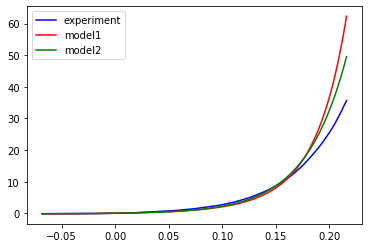

In [22]:
model1 = Model(I)
model2 = Model(I2)
x = room[['V(V)', 'T(K)']].values.T
y = room['I(nA)'].values
data = RealData(x, y)
myodr = ODR(data, model1, beta0 = [1, 1.2, 1e-21], maxit = 1000)
myoutput = myodr.run()
myoutput.pprint()
print('---------------------------------------------------')
model2 = Model(I2)
myodr2 = ODR(data, model2, beta0 = [1.0, 1.0], maxit = 1000)
myoutput2 = myodr2.run()
myoutput2.pprint()

I_model1 = I(myoutput.beta, x)
I_model2 = I2(myoutput2.beta, x)

plt.plot(room['V(V)'] ,y, 'b', label = 'experiment')
plt.plot(room['V(V)'] ,I_model1, 'r', label = 'model1')
plt.plot(room['V(V)'] ,I_model2, 'g', label = 'model2')
plt.legend()

Beta: [1.22362063e-04 4.50754991e-09 2.82010944e-20]
Beta Std Error: [7.8264715e-07 1.2255596e-10 0.0000000e+00]
Beta Covariance: [[ 8.21180819e-09 -8.74597904e-13  0.00000000e+00]
 [-8.74597904e-13  2.01361137e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Residual Variance: 7.459216616637933e-05
Inverse Condition #: 9.566220581759689e-05
Reason(s) for Halting:
  Problem is not full rank at solution
  Sum of squares convergence
---------------------------------------------------
Beta: [0.04645058 1.69087251]
Beta Std Error: [0.00033187 0.00411734]
Beta Covariance: [[0.00224221 0.02481701]
 [0.02481701 0.34511566]]
Residual Variance: 4.912107652873529e-05
Inverse Condition #: 0.035085480006416966
Reason(s) for Halting:
  Sum of squares convergence


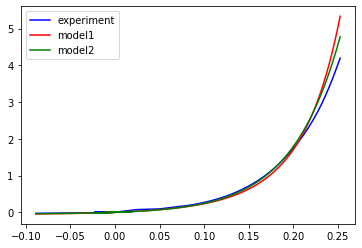

In [23]:
model1 = Model(I)
model2 = Model(I2)
x = boil[['V(V)', 'T(K)']].values.T
y = boil['I(nA)'].values
data = RealData(x, y)
myodr = ODR(data, model1, beta0 = [1, 1.2, 1e-21], maxit = 1000)
myoutput = myodr.run()
myoutput.pprint()
print('---------------------------------------------------')
model2 = Model(I2)
myodr2 = ODR(data, model2, beta0 = [1.0, 1.0], maxit = 1000)
myoutput2 = myodr2.run()
myoutput2.pprint()

I_model1 = I(myoutput.beta, x)
I_model2 = I2(myoutput2.beta, x)

plt.plot(boil['V(V)'] ,y, 'b', label = 'experiment')
plt.plot(boil['V(V)'] ,I_model1, 'r', label = 'model1')
plt.plot(boil['V(V)'] ,I_model2, 'g', label = 'model2')
plt.legend()

Beta: [6.48265636e-05 1.99671310e-09 1.65667599e-20]
Beta Std Error: [5.28066983e-07 4.17706949e-11 0.00000000e+00]
Beta Covariance: [[ 3.27108998e-09 -1.29098305e-13  0.00000000e+00]
 [-1.29098305e-13  2.04671731e-17  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Residual Variance: 8.524826288057783e-05
Inverse Condition #: 5.712812043744999e-05
Reason(s) for Halting:
  Problem is not full rank at solution
  Sum of squares convergence
---------------------------------------------------
Beta: [0.02640353 1.60053329]
Beta Std Error: [0.00016174 0.0024552 ]
Beta Covariance: [[0.00098172 0.01277593]
 [0.01277593 0.22622761]]
Residual Variance: 2.6645828445382705e-05
Inverse Condition #: 0.033098697896409165
Reason(s) for Halting:
  Sum of squares convergence


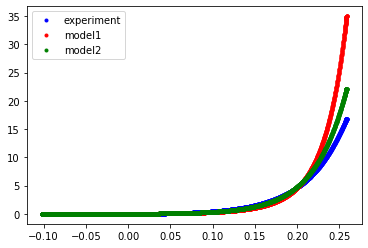

In [26]:
model1 = Model(I)
model2 = Model(I2)
x = ice[['V(V)', 'T(K)']].values.T
y = ice['I(nA)'].values
data = RealData(x, y)
myodr = ODR(data, model1, beta0 = [1, 1.2, 1e-21], maxit = 1000)
myoutput = myodr.run()
myoutput.pprint()
print('---------------------------------------------------')
model2 = Model(I2)
myodr2 = ODR(data, model2, beta0 = [1.0, 1.0], maxit = 1000)
myoutput2 = myodr2.run()
myoutput2.pprint()

I_model1 = I(myoutput.beta, x)
I_model2 = I2(myoutput2.beta, x)

plt.plot(ice['V(V)'] ,y, 'b.', label = 'experiment')
plt.plot(ice['V(V)'] ,I_model1, 'r.', label = 'model1')
plt.plot(ice['V(V)'] ,I_model2, 'g.', label = 'model2')
plt.legend()

Beta: [ 1.00000000e+00 -1.30659288e-22  4.24125272e-20]
Beta Std Error: [0.00000000e+00 1.27085587e-14 0.00000000e+00]
Beta Covariance: [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.70904699e-42 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Residual Variance: 94501477568363.7
Inverse Condition #: 1.0000000000000002
Reason(s) for Halting:
  Problem is not full rank at solution
  Parameter convergence
---------------------------------------------------
Beta: [3.72640649e-62 1.00000000e+00]
Beta Std Error: [9.26522415e-59 0.00000000e+00]
Beta Covariance: [[2.75987169e-122 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000]]
Residual Variance: 311044.81784601766
Inverse Condition #: 1.0
Reason(s) for Halting:
  Problem is not full rank at solution
  Sum of squares convergence


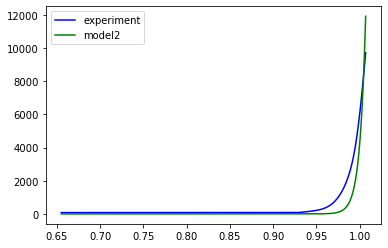

In [29]:
model1 = Model(I)
model2 = Model(I2)
x = N2[['V(V)', 'T(K)']].values.T
y = N2['I(nA)'].values
data = RealData(x, y)
myodr = ODR(data, model1, beta0 = [1, 1.2, 1e-21], maxit = 1000)
myoutput = myodr.run()
myoutput.pprint()
print('---------------------------------------------------')
model2 = Model(I2)
myodr2 = ODR(data, model2, beta0 = [1.0, 1.0], maxit = 1000)
myoutput2 = myodr2.run()
myoutput2.pprint()

I_model1 = I(myoutput.beta, x)
I_model2 = I2(myoutput2.beta, x)

plt.plot(N2['V(V)'] ,y, 'b', label = 'experiment')
# plt.plot(N2['V(V)'] ,I_model1, 'r', label = 'model1')
plt.plot(N2['V(V)'] ,I_model2, 'g', label = 'model2')
plt.legend()

In [11]:
concat_data = pd.concat([room, boil, ice])
model1 = Model(I)
model2 = Model(I2)
x = concat_data[['V(V)', 'T(K)']].values.T
y = concat_data['I(nA)'].values
data = RealData(x, y)
myodr = ODR(data, model1, beta0 = [1, 1.2, 1e-21], maxit = 1000)
myoutput = myodr.run()
myoutput.pprint()
print('---------------------------------------------------')
model2 = Model(I2)
myodr2 = ODR(data, model2, beta0 = [1.0, 1.0], maxit = 1000)
myoutput2 = myodr2.run()
myoutput2.pprint()

I_model1 = I(myoutput.beta, x)
I_model2 = I2(myoutput2.beta, x)

Beta: [ 1.19189094e-05 -9.52539741e-13 -1.14194908e-20]
Beta Std Error: [1.30453313e-07 3.64285606e-14 0.00000000e+00]
Beta Covariance: [[ 8.89044770e-12 -1.63050779e-18  0.00000000e+00]
 [-1.63050779e-18  6.93262045e-25  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Residual Variance: 0.0019141968525296911
Inverse Condition #: 1.7548100665813462e-07
Reason(s) for Halting:
  Problem is not full rank at solution
  Sum of squares convergence
---------------------------------------------------
Beta: [0.05702326 1.35695919]
Beta Std Error: [0.00081018 0.00602948]
Beta Covariance: [[0.00056708 0.00326081]
 [0.00326081 0.03140786]]
Residual Variance: 0.0011574996844562122
Inverse Condition #: 0.08275683137112573
Reason(s) for Halting:
  Sum of squares convergence


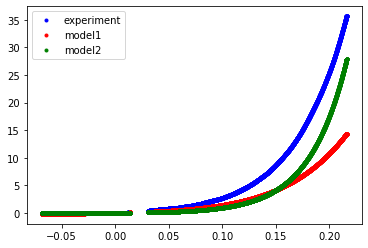

In [15]:
plt.plot(room['V(V)'] ,room['I(nA)'], 'b.', label = 'experiment')
plt.plot(room['V(V)'] ,I(myoutput.beta, room[['V(V)', 'T(K)']].values.T ), 'r.',  label = 'model1')
plt.plot(room['V(V)'] ,I2(myoutput2.beta, room[['V(V)', 'T(K)']].values.T ), 'g.', label = 'model2')
plt.legend()

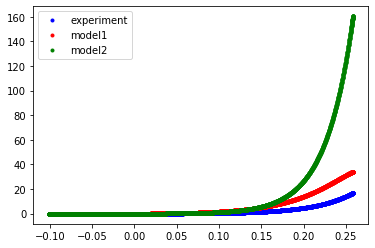

In [16]:
plt.plot(ice['V(V)'] ,ice['I(nA)'], 'b.', label = 'experiment')
plt.plot(ice['V(V)'] ,I(myoutput.beta, ice[['V(V)', 'T(K)']].values.T ), 'r.', label = 'model1')
plt.plot(ice['V(V)'] ,I2(myoutput2.beta, ice[['V(V)', 'T(K)']].values.T ), 'g.', label = 'model2')
plt.legend()

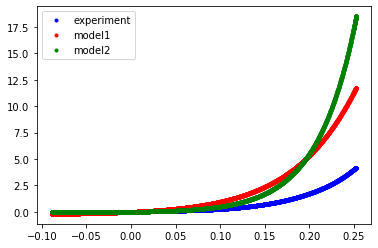

In [17]:
plt.plot(boil['V(V)'] ,boil['I(nA)'], 'b.', label = 'experiment')
plt.plot(boil['V(V)'] ,I(myoutput.beta, boil[['V(V)', 'T(K)']].values.T ), 'r.', label = 'model1')
plt.plot(boil['V(V)'] ,I2(myoutput2.beta, boil[['V(V)', 'T(K)']].values.T ), 'g.', label = 'model2')
plt.legend()

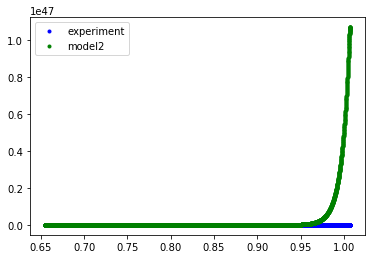

In [21]:
plt.plot(N2['V(V)'] ,N2['I(nA)'], 'b.', label = 'experiment')
# plt.plot(N2['V(V)'] ,I(myoutput.beta, N2[['V(V)', 'T(K)']].values.T ), 'r.', label = 'model1')
plt.plot(N2['V(V)'] ,I2(myoutput2.beta, N2[['V(V)', 'T(K)']].values.T ), 'g.', label = 'model2')
plt.legend()